In [1]:
import os
os.chdir(r'/Users/zhanghui/商业分析工具和应用/Python/Python数据分析与数据化运营-第一版-python2附件/chapter6')

In [2]:
# 导入库
import numpy as np  # 导入numpy库
import pandas as pd  # 导入pandas库
from sklearn.ensemble import GradientBoostingRegressor  # 集成方法回归库
from sklearn.model_selection import GridSearchCV  # 导入交叉检验库
import matplotlib.pyplot as plt  # 导入图形展示库

In [3]:
raw_data = pd.read_table('products_sales.txt',delimiter = ',')
raw_data.head()

,limit_infor,campaign_type,campaign_level,product_level,resource_amount,email_rate,price,discount_rate,hour_resouces,campaign_fee,orders
0,0,6,0,1,1,0.08,140.0,0.83,93,888,1981
1,0,0,0,1,1,0.10,144.0,0.75,150,836,986
2,0,1,1,1,1,0.12,149.0,0.84,86,1330,1416
3,0,3,1,2,1,0.12,141.0,0.82,95,2273,2368
4,0,0,0,1,1,0.10,146.0,0.59,73,1456,1529


In [30]:
print ('{:*^60}'.format('Data dtypes:'))
print (raw_data.dtypes)  # 打印数据类型
print ('{:*^60}'.format('Data DESC:'))
print (raw_data.describe().round(1).T)  # 打印原始数据基本描述性信息

************************Data dtypes:************************
limit_infor          int64
campaign_type        int64
campaign_level       int64
product_level        int64
resource_amount      int64
email_rate         float64
price              float64
discount_rate      float64
hour_resouces        int64
campaign_fee         int64
orders               int64
dtype: object
*************************Data DESC:*************************
                 count    mean     std    min     25%     50%     75%      max
limit_infor      731.0     0.0     0.4    0.0     0.0     0.0     0.0     10.0
campaign_type    731.0     3.0     2.0    0.0     1.0     3.0     5.0      6.0
campaign_level   731.0     0.7     0.5    0.0     0.0     1.0     1.0      1.0
product_level    731.0     1.4     0.5    1.0     1.0     1.0     2.0      3.0
resource_amount  731.0     5.0     1.8    1.0     3.0     5.0     7.0      9.0
email_rate       731.0     0.5     0.2    0.1     0.3     0.5     0.6      0.8
price         

In [15]:
#缺失值审查
na_cols = raw_data.isnull().any(axis = 0)
print('{:*^60}'.format('NA cols:'))
print(na_cols[na_cols] == True)
print('Total NA line is:{0}'.format(raw_data.isnull().any(axis = 1).sum()))

**************************NA cols:**************************
price    True
dtype: bool
Total NA line is:2


In [31]:
#相关性分析
print ('{:*^60}'.format('Correlation Analyze:'))
short_name = ['li', 'ct', 'cl', 'pl', 'ra', 'er', 'price', 'dr', 'hr', 'cf', 'orders']
long_name = raw_data.columns
name_dict = dict(zip(long_name, short_name))
print (raw_data.corr().round(2).rename(index=name_dict, columns=name_dict))  # 输出所有输入特征变量以及预测变量的相关性矩阵
print (name_dict)

********************Correlation Analyze:********************
          li    ct    cl    pl    ra    er  price    dr    hr    cf  orders
li      1.00 -0.03 -0.08 -0.04  0.05  0.04  -0.02  0.00  0.01 -0.04   -0.02
ct     -0.03  1.00  0.04  0.03  0.01 -0.01  -0.05 -0.01  0.06  0.06    0.06
cl     -0.08  0.04  1.00  0.06  0.05  0.05   0.02  0.02 -0.52  0.26    0.05
pl     -0.04  0.03  0.06  1.00 -0.12 -0.12   0.59 -0.04 -0.25 -0.23   -0.30
ra      0.05  0.01  0.05 -0.12  1.00  0.98   0.13  0.15  0.54  0.46    0.62
er      0.04 -0.01  0.05 -0.12  0.98  1.00   0.14  0.18  0.54  0.47    0.63
price  -0.02 -0.05  0.02  0.59  0.13  0.14   1.00  0.25 -0.08 -0.11   -0.10
dr      0.00 -0.01  0.02 -0.04  0.15  0.18   0.25  1.00  0.17  0.19    0.23
hr      0.01  0.06 -0.52 -0.25  0.54  0.54  -0.08  0.17  1.00  0.32    0.66
cf     -0.04  0.06  0.26 -0.23  0.46  0.47  -0.11  0.19  0.32  1.00    0.76
orders -0.02  0.06  0.05 -0.30  0.62  0.63  -0.10  0.23  0.66  0.76    1.00
{'limit_infor': 'li', 'camp

In [32]:
# 数据预处理
# 异常值处理
sales_data = raw_data.fillna(raw_data['price'].mean())  # 缺失值替换为均值
# sales_data = raw_data.drop('email_rate',axis=1) # 丢弃缺失值
sales_data = sales_data[sales_data['limit_infor'].isin((0, 1))]  # 只保留促销值为0和1的记录
sales_data['campaign_fee'] = sales_data['campaign_fee'].replace(33380, sales_data['campaign_fee'].mean())  # 将异常极大值替换为均值
print ('{:*^60}'.format('transformed data:'))
print (sales_data.describe().round(2).T.rename(index=name_dict))  # 打印处理完成数据基本描述性信息

*********************transformed data:**********************
        count     mean      std     min      25%      50%      75%      max
li      730.0     0.03     0.17    0.00     0.00     0.00     0.00     1.00
ct      730.0     3.00     2.01    0.00     1.00     3.00     5.00     6.00
cl      730.0     0.68     0.47    0.00     0.00     1.00     1.00     1.00
pl      730.0     1.40     0.55    1.00     1.00     1.00     2.00     3.00
ra      730.0     4.95     1.84    1.00     3.00     5.00     7.00     9.00
er      730.0     0.47     0.16    0.08     0.34     0.48     0.61     0.84
price   730.0   162.82    14.26  100.00   152.00   163.00   173.00   197.00
dr      730.0     0.81     0.08    0.49     0.77     0.82     0.87     0.98
hr      730.0   848.51   687.03    2.00   315.25   717.00  1096.50  3410.00
cf      730.0  3655.61  1561.27   20.00  2495.00  3660.00  4783.25  6946.00
orders  730.0  4531.27  1933.85   22.00  3196.50  4566.00  6021.25  8714.00


In [33]:
# 分割数据集X和y
X = sales_data.ix[:, :-1]  # 分割X
y = sales_data.ix[:, -1]  # 分割y

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  
/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
 

In [34]:
## 模型最优化参数训练及检验
model_gbr = GradientBoostingRegressor()  # 建立GradientBoostingRegressor回归对象
parameters = {'loss': ['ls', 'lad', 'huber', 'quantile'],
              'min_samples_leaf': [1, 2, 3, 4, 5],
              'alpha': [0.1, 0.3, 0.6, 0.9]}  # 定义要优化的参数信息
model_gs = GridSearchCV(estimator=model_gbr, param_grid=parameters, cv=5)  # 建立交叉检验模型对象
model_gs.fit(X, y)  # 训练交叉检验模型
print ('Best score is:', model_gs.best_score_)  # 获得交叉检验模型得出的最优得分
print ('Best parameter is:', model_gs.best_params_)  # 获得交叉检验模型得出的最优参数

Best score is: 0.9315453619342527
Best parameter is: {'alpha': 0.9, 'loss': 'huber', 'min_samples_leaf': 3}


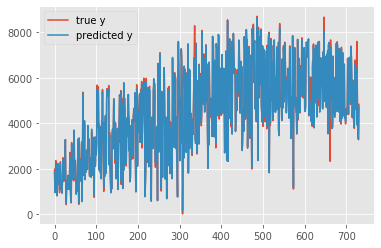

In [27]:
# 获取最佳训练模型
model_best = model_gs.best_estimator_  # 获得交叉检验模型得出的最优模型对象
model_best.fit(X, y)  # 训练最优模型
plt.style.use("ggplot")  # 应用ggplot自带样式库
plt.figure()  # 建立画布对象
plt.plot(np.arange(X.shape[0]), y, label='true y')  # 画出原始变量的曲线
plt.plot(np.arange(X.shape[0]), model_best.predict(X), label='predicted y')  # 画出预测变量曲线
plt.legend(loc=0)  # 设置图例位置
plt.show() 

In [28]:
New_X = np.array([[1, 1, 0, 1, 15, 0.5, 177, 0.66, 101, 798]])  # 要预测的新数据记录
print ('{:*^60}'.format('Predicted orders:'))
print (model_best.predict(New_X).round(0))  # 打印输出预测值

*********************Predicted orders:**********************
[880.]
